# Visualization of three years of salary data from /r/cscareerquestions

Every three months, users contribute to a salary sharing thread for interns, new graduates, and experienced hires. The data dates back to the beginning of 2016. These threads are generally quite accurate (unlike Glassdoor) and are a useful reference to those searching for internships or full-time jobs. The goal of this analysis is to visualize relationships in the data to extract additional information from the large amount of data that has been accrued over time.

Currently, the analysis only covers base salary due to the difficulty in parsing additional compensation.

In [36]:
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 16})
date_format = DateFormatter('%b-%y')
money_format = ticker.FormatStrFormatter('$%1.0f')
name_map = {
    'FB': 'Facebook',
    'facebook': 'Facebook',
    'MSFT': 'Microsoft',
    'BigN': 'Big N',
    'Snapchat': 'Snap'
}

## Load data and data cleaning

In [37]:
filename = 'salary_data.csv'
salary_data = pd.read_csv(filename)
salary_data['Experience Level'] = salary_data['Experience Level'].apply(lambda e: e + ' Grads' if e == 'New' else e)
salary_data['Salary'] = pd.to_numeric(salary_data['Salary'])
salary_data['Date'] = pd.to_datetime(salary_data['Date'])

# some data was parsed incorrectly from reddit and resulted in inaccurate salaries
salary_data = salary_data[salary_data['Salary'] > 19000]
salary_data = salary_data.fillna(value='Unknown')
for key, value in name_map.items():
    reg = '(?i)' + key
    salary_data['Company/Industry'] = salary_data['Company/Industry'].replace(reg, value, regex=True)

## Summary statistics
There are almost 2,000 observations (U.S. only) from the last three years of salary sharing threads. 

In [38]:
salary_data.groupby(by='Experience Level').describe()

Salary                                                 \
                  count           mean           std      min      25%   
Experience Level                                                         
Experienced       630.0  120725.782540  41760.576963  40000.0  90000.0   
Interns           582.0   78374.281787  27126.578425  19240.0  54080.0   
New Grads         678.0   99111.932153  24949.758661  30000.0  78000.0   

                                                
                       50%       75%       max  
Experience Level                                
Experienced       115000.0  145000.0  400000.0  
Interns            85280.0   96000.0  208644.8  
New Grads         105000.0  116000.0  175000.0

## Visualization

The first plot is the average salary over time for each group.

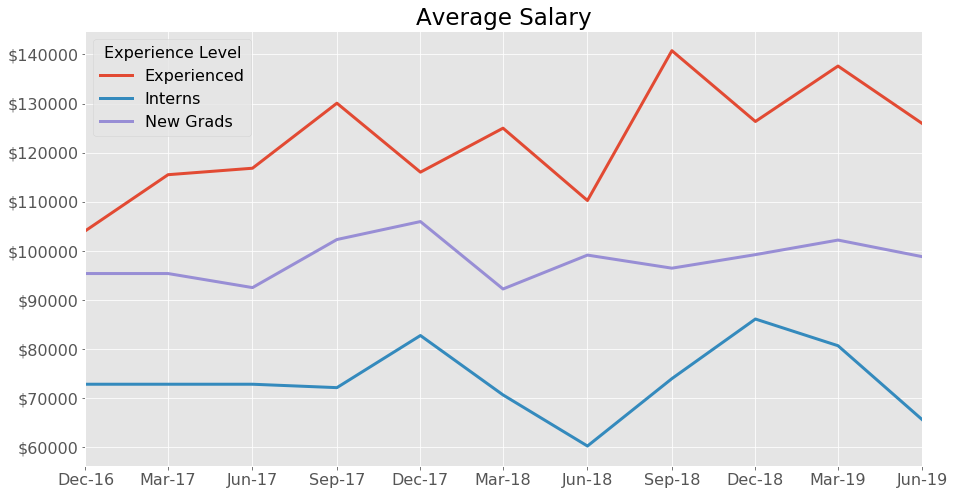

In [39]:
salaries = salary_data.Salary
grouped = salary_data.groupby(by=['Experience Level', 'Date'])

grouped_mean = grouped.mean()
grouped_mean = grouped_mean.unstack(level=0).Salary
grouped_mean.index = grouped_mean.index.date

# Some missing values in the interns/new grads threads
grouped_mean = grouped_mean.fillna(method='ffill')

ax = grouped_mean.plot(figsize=(15,8), title='Average Salary', lw=3, grid=True)
ax.xaxis.set_major_formatter(date_format)
ax.yaxis.set_major_formatter(money_format)
plt.savefig('salary_time_series.png', bbox_inches='tight')

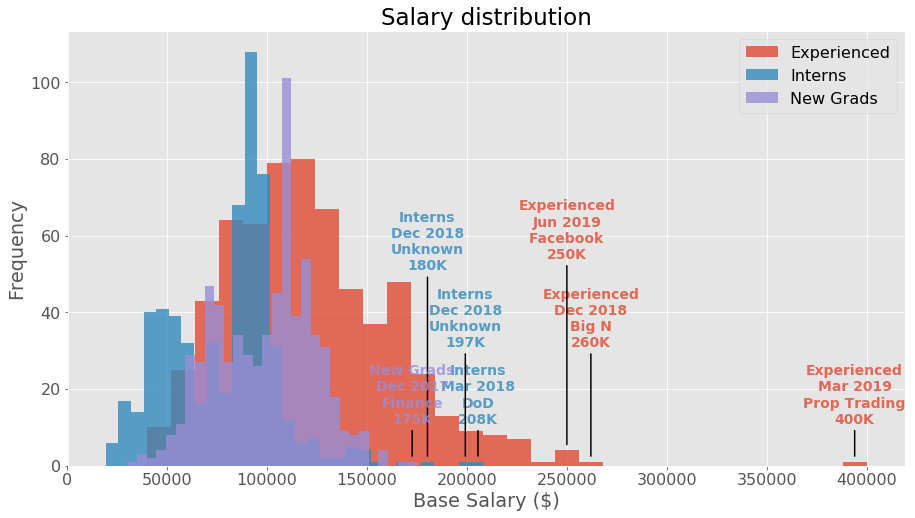

In [40]:
# Reference: https://stackoverflow.com/questions/35780048/labelling-a-matplotlib-histogram-bin-with-an-arrow

exp_gp = salary_data.groupby(by='Experience Level')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
for group, data in exp_gp:
    ybins, xbins, _ = ax.hist(data.Salary, bins=30, label=group,alpha=0.8)
    # Get top three salaries
    outliers = data[stats.zscore(data.Salary) > 3].sort_values(by='Salary', ascending=False)[:3]
    annotate_height = 10
    for idx, outlier in outliers.iterrows():
        company = outlier['Company/Industry']
        if company == '0':
            company = 'Unknown'
        salary = outlier['Salary']
        experience = outlier['Experience Level']
        date = outlier['Date'].strftime('%b %Y')
        ind_bin = np.where(xbins >= salary)[0]
        if len(ind_bin) > 0 and ind_bin[0] > 0:
            x_bin = xbins[ind_bin[0]-1]/2. + xbins[ind_bin[0]]/2.
            y_bin = ybins[ind_bin[0]-1]
        
        abbreviated_sal = str(int(salary/1000))+'K'
        annotation = '\n'.join([experience, date, company, str(abbreviated_sal)])
        ax.annotate(annotation,
                    size=14,weight='bold',
                    xy=(x_bin, y_bin+1), xycoords='data',
                    xytext=(x_bin, y_bin+annotate_height),
                    textcoords='data',
                    color=ax.patches[-1].get_facecolor(),
                    ha='center',
                    arrowprops=dict(arrowstyle="-",lw=1.5,
                                    connectionstyle="arc3", color='black'))
        annotate_height += 20

ax.set_title('Salary distribution')
ax.set_ylabel('Frequency')
ax.set_xlabel('Base Salary ($)')
plt.legend()
plt.savefig('salary_distribution.png', bbox_inches='tight')

## Salaries by industry


In [41]:
finance_words = 'Business|Finance|Trading|Bank|Accounting|Fund|HFT|Prop|Financial|Insurance|Fintech|Capital|Consult|Bloomberg|Citadel|Quant|JP|Goldman|GS|Citi|Deloitte|Street|Barclays'
healthcare_words = 'Health|Hospital|Medicine|Medical|Bio|Epic'
government_words = 'Government|Contractor|Defense|Federal|Military|Public'
academia_words = 'Academia|University|College|Education'
startup_words = 'Start|small|Breakout'
big4_words = 'Big 4|Facebook|Microsoft|Google|Amazon|Bezos|Big N|Big Four|AWS|AMZN'

industry_dict = {'Finance': finance_words,
                'Healthcare': healthcare_words,
                'Government': government_words,
                'Academia': academia_words,
                'Startup': startup_words,
                'Big 4': big4_words}

remaining = salary_data

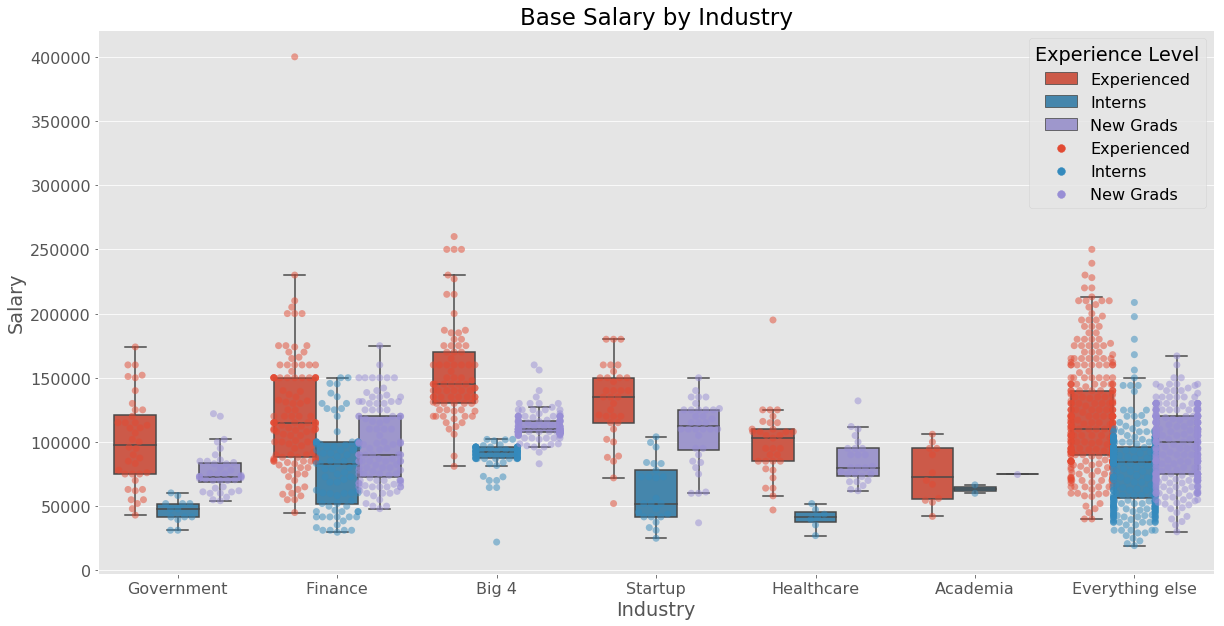

In [42]:
partitions = []
industry_labels = []

for industry, keywords in industry_dict.items():
    industry_jobs = remaining[remaining['Company/Industry'].str.contains(keywords, flags=re.IGNORECASE)]
    partitions.append(industry_jobs)
    industry_labels.append(industry)
    remaining = remaining.drop(labels=industry_jobs.index)
partitions.append(remaining)
industry_labels.append('Everything else')

big_df = pd.DataFrame()
for ind, partition in enumerate(partitions):
    partition['Industry'] = industry_labels[ind]
    big_df = big_df.append(partition)

fig1, box = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

sns.boxplot(x="Industry", hue="Experience Level", y="Salary", data=big_df.reset_index(), ax=box,showfliers=False)
sns.swarmplot(x="Industry", hue="Experience Level", y="Salary", data=big_df.reset_index(), ax=box, alpha=0.5,dodge=True,size=7)
box.set_title('Base Salary by Industry')

plt.savefig('salary_by_industry.png', bbox_inches='tight')

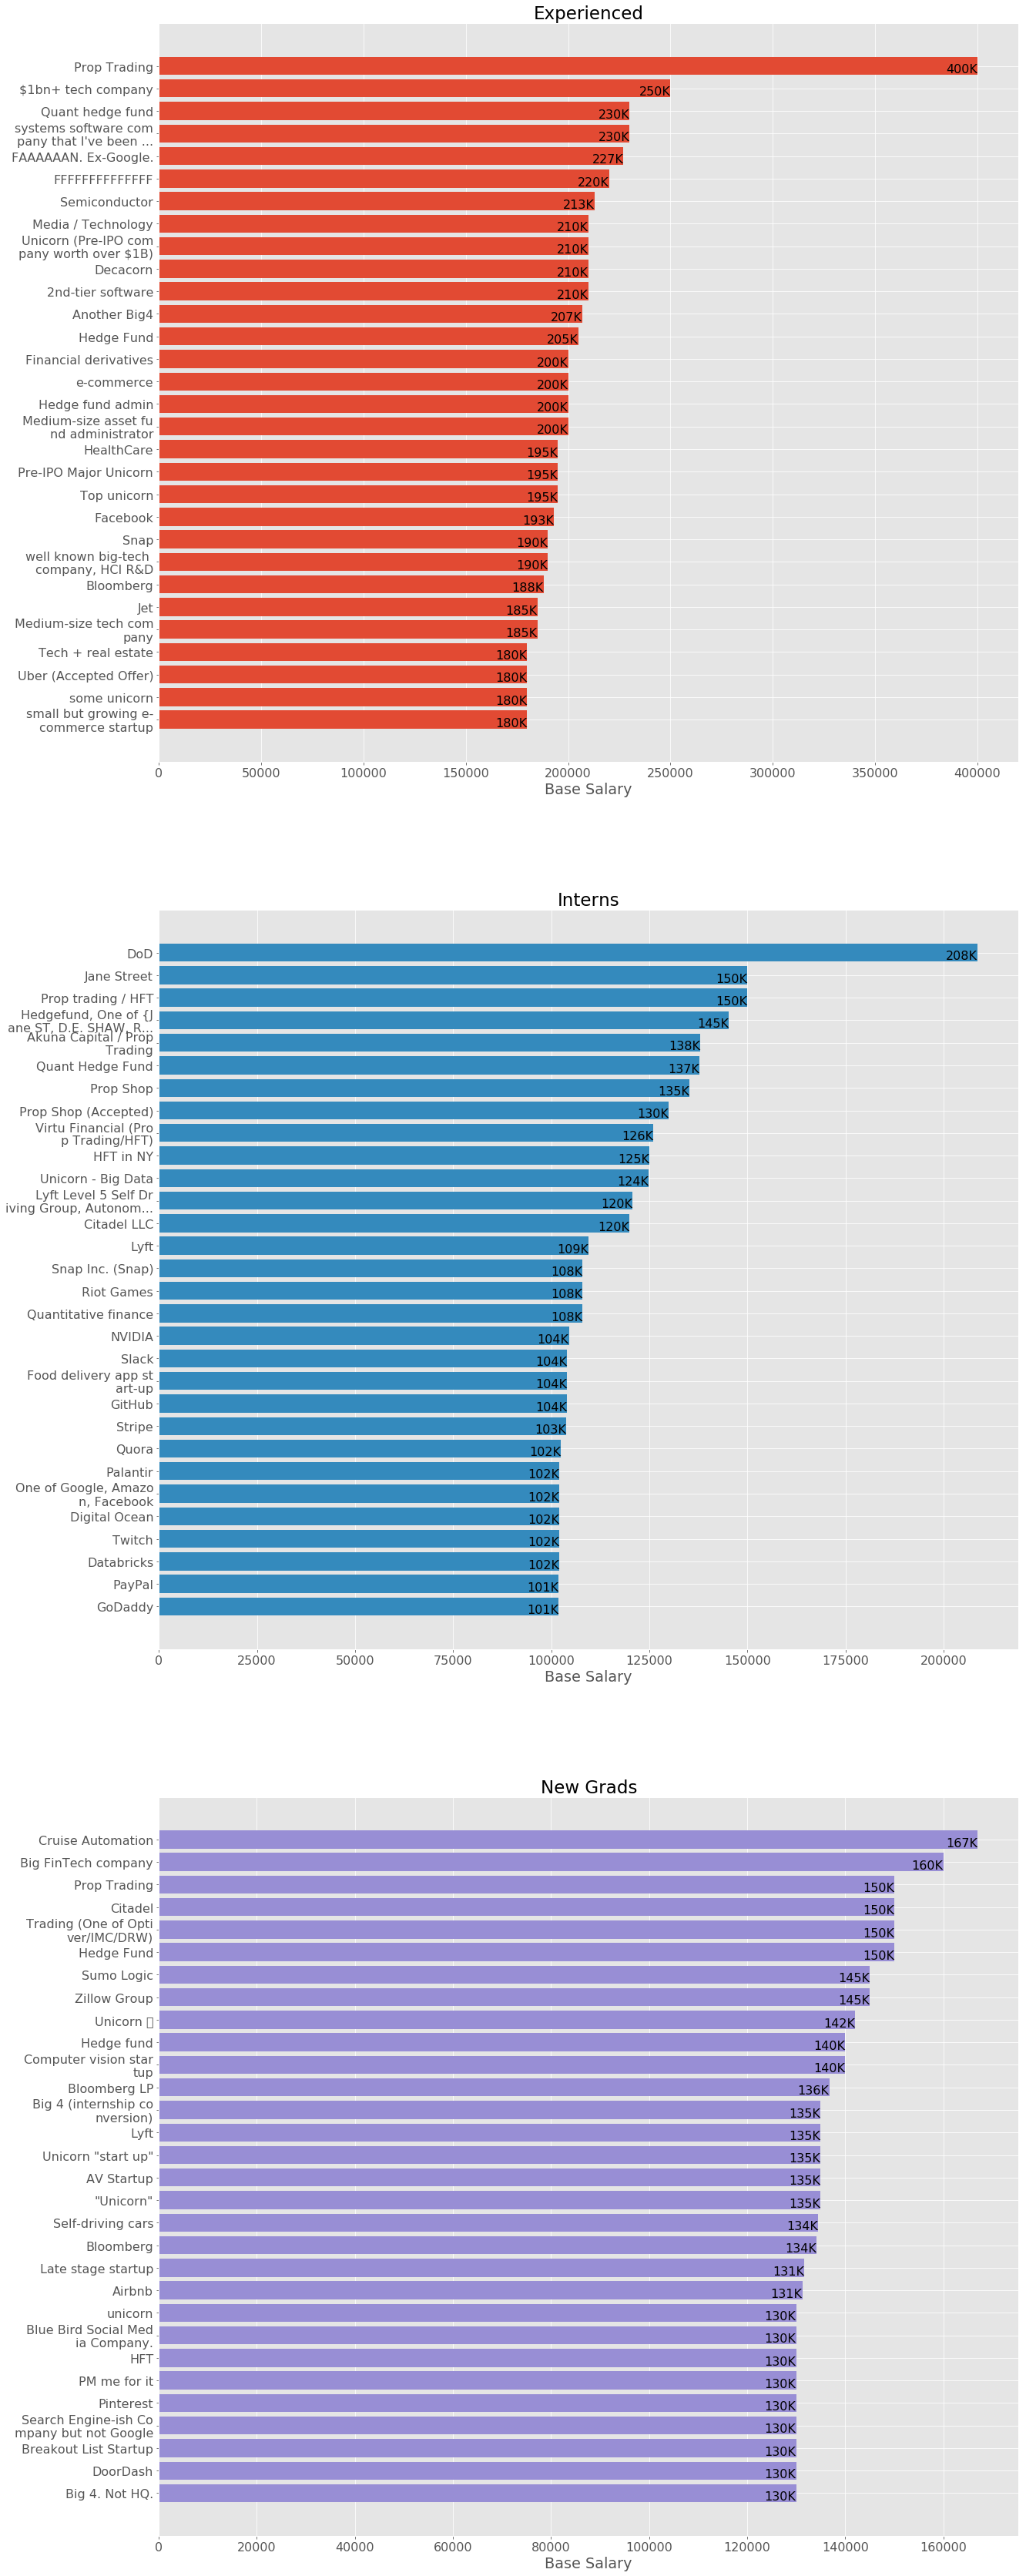

In [80]:
top_salaries = salary_data[salary_data['Company/Industry'] != '0']
top_salaries = top_salaries.groupby(by=['Experience Level'])

#Get top 50 salaries first and then drop duplicates
#top30 = top_salaries.apply(lambda e: e.sort_values(by='Salary').tail(50))
fig2, top_sal_plt = plt.subplots(nrows=3,ncols=1,figsize=(20,60))
colors = ['#E24A33', '#348ABD', '#988ED5']
idx = 0
for experience, data in top_salaries:
    # take average of company salaries
    average_salaries = data.groupby(by='Company/Industry').mean()
    data = average_salaries.sort_values(by='Salary')
    # Remove duplicate companies, keep only largest
    data = data.tail(30)
    edited_labels = []
    for company, salary in data.Salary.iteritems():
        if len(company) > 21:
            modified = company[:20] + '\n' + company[20:40]
            if len(company) > 40:
                modified += "..."
            edited_labels.append(modified)

        else:
            edited_labels.append(company)
    
    subplot = top_sal_plt[idx]
    subplot.barh(edited_labels,data.Salary, color=colors[idx])
    subplot.set_title(experience)
    subplot.set_xlabel('Base Salary')
    bars = subplot.patches
    for bar in bars:
        width = bar.get_width()
        label = str(int(width/1000))+'K'
        subplot.text(width, bar.get_y(), label,
            ha='right', va='bottom')
    idx += 1
    
plt.savefig('salaries_top_companies.png', bbox_inches='tight')

In [75]:
amzn = salary_data[(salary_data['Experience Level'] == 'New Grads') & (salary_data['Company/Industry'] == 'Amazon')]
print(amzn.Salary.mean())

112862.068966
